# Import Data

In [1]:
import os

!git clone https://github.com/CSSEGISandData/COVID-19.git
MAIN_FOLDER = "/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

CONFIRMED_PATH = os.path.join(MAIN_FOLDER, "time_series_19-covid-Confirmed.csv")
DEATHS_PATH = os.path.join(MAIN_FOLDER, "time_series_19-covid-Deaths.csv")
RECOVERED_PATH = os.path.join(MAIN_FOLDER, "time_series_19-covid-Recovered.csv")

Cloning into 'COVID-19'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 10732 (delta 73), reused 126 (delta 40), pack-reused 10572
Receiving objects: 100% (10732/10732), 39.92 MiB | 42.50 MiB/s, done.
Resolving deltas: 100% (5137/5137), done.


In [0]:
import pandas as pd

df_confirmed = pd.read_csv(CONFIRMED_PATH)
df_deaths = pd.read_csv(DEATHS_PATH)
df_recovered = pd.read_csv(RECOVERED_PATH)

# S curve regression

## Group data by country

In [0]:
df_confirmed = df_confirmed.drop(columns=['Lat', 'Long'])
df_confirmed["Province/State"] = df_confirmed["Province/State"].fillna(df_confirmed["Country/Region"])

df_confirmed_bycountry = df_confirmed.groupby('Country/Region').sum()
df_confirmed_bycountry.loc["Total"] = df_confirmed_bycountry.sum(axis=0)
maximums = df_confirmed_bycountry.iloc[:, -1]
df_confirmed_bycountry_norm = df_confirmed_bycountry.div(maximums.to_numpy(), axis=0)

## Define sigmoid and Tanh function

In [0]:
import numpy as np

def sigmoid(x, x0, y0, c, k):
  y = c / (1 + np.exp(-k*(x-x0))) + y0
  return y

def tanh(x, x0, y0, c, k):
  y = c * np.tanh(k * (x-x0)) + y0
  return y

## Optimize loop

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from inspect import signature

def fit_confirmed(df, function, prediction_range = None, current_bounds = None, initial_guess = None):
  x = np.arange(df.shape[0])
  y = df.to_numpy()

  if initial_guess is None:
    initial_guess = np.ones(len(signature(function).parameters) - 1)

  if current_bounds is None:
    popt, pcov = curve_fit(function, x, y, p0 = initial_guess)
  else:
    popt, pcov = curve_fit(function, x, y, p0 = initial_guess, bounds = current_bounds)
  
  if prediction_range is None:
    prediction_range = x

  pxp=function(prediction_range, *popt)

  best_fit = function(x, *popt)
  loss = sum((y - best_fit)**2)

  plt.subplots(figsize=(14,10))
  plt.plot(x, y, '.', prediction_range, pxp, '-')
  plt.xlabel('Days')
  plt.ylabel('Confirmed',rotation='vertical') 
  plt.grid(True)
  plt.title(f"Fit with {function.__name__}, loss {round(loss, 5)}, x0: {round(popt[0], 3)}, y0: {round(popt[1], 3)}, c: {round(popt[2], 3)}, k: {round(popt[3], 3)}")
  plt.show()

  return popt, loss

## China prediction for confirmed cases

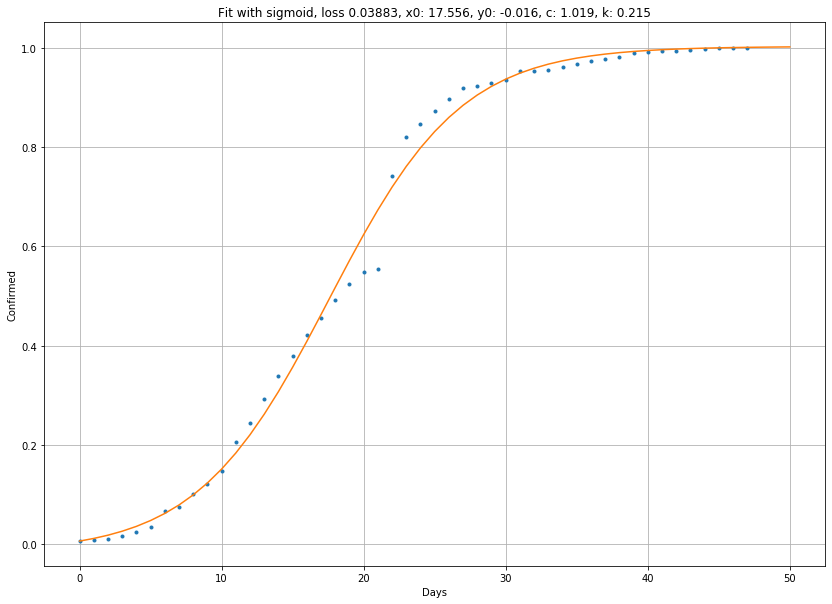

(array([ 1.75557146e+01, -1.62929466e-02,  1.01886035e+00,  2.14736570e-01]),
 0.038834323641476216)

In [6]:
china_confirmed = df_confirmed_bycountry_norm.loc["Mainland China",:]
offset = 0 # days
prediction = 3 # days
fit_confirmed(china_confirmed[offset:], sigmoid, 
              prediction_range = np.arange(china_confirmed[offset:].shape[0] + prediction),
              current_bounds = ([-np.inf, -np.inf, -np.inf, 0.0], np.inf))

## France prediction for confirmed cases

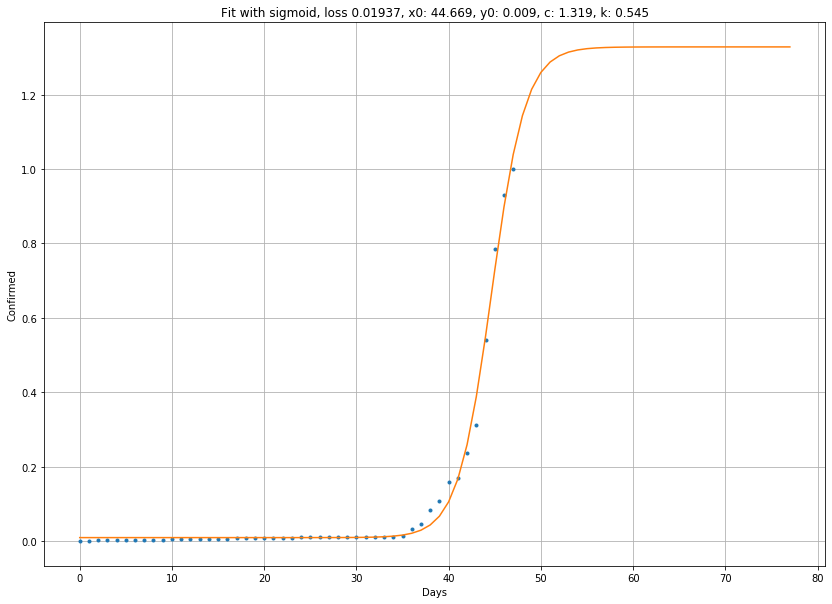

(array([4.46693102e+01, 9.37375809e-03, 1.31887235e+00, 5.44672573e-01]),
 0.019370495643162487)

In [7]:
france_confirmed = df_confirmed_bycountry_norm.loc["France",:]
offset = 0 # days
prediction = 30 # days
fit_confirmed(france_confirmed[offset:], sigmoid, 
              prediction_range = np.arange(france_confirmed[offset:].shape[0] + prediction),
              initial_guess = [1.0, 1.0, 1.0, 1.0])

# Italy prediction for confirmed cases

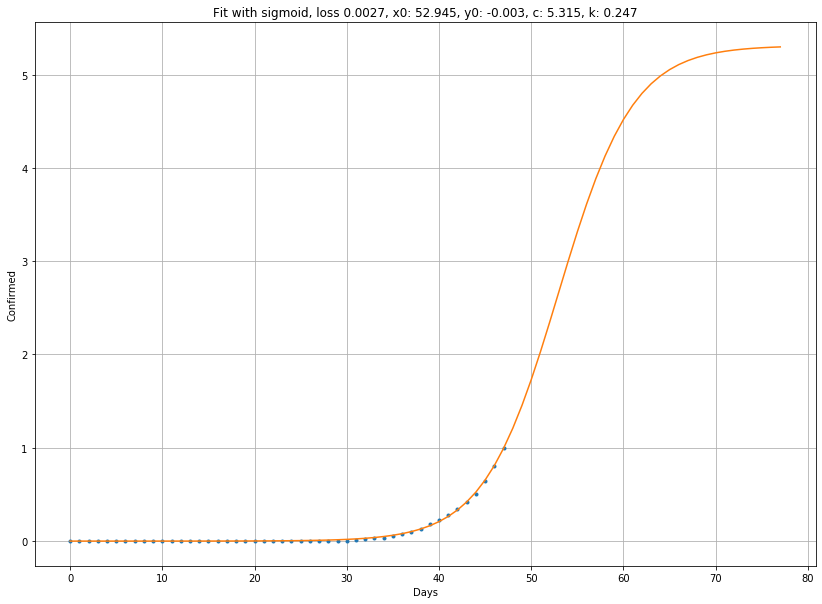

(array([ 5.29445003e+01, -3.23694306e-03,  5.31477120e+00,  2.46960050e-01]),
 0.002698535662908162)

In [8]:
italy_confirmed = df_confirmed_bycountry_norm.loc["Italy",:]
offset = 0 # days
prediction = 30 # days
fit_confirmed(italy_confirmed[offset:], sigmoid, 
              prediction_range = np.arange(italy_confirmed[offset:].shape[0] + prediction),
              initial_guess = [np.median(italy_confirmed[offset:]), 1.0, 1.0, 1.0])

# South Korea prediction for confirmed cases

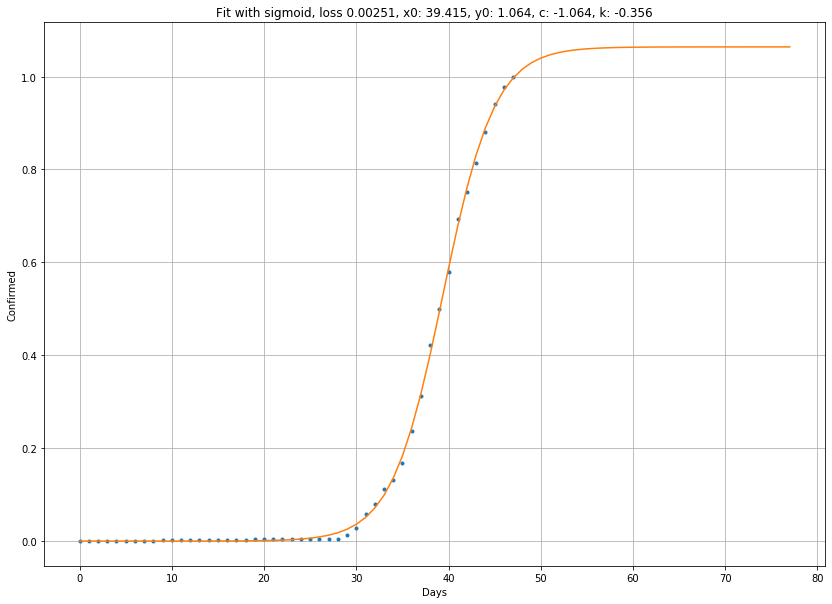

(array([39.4145724 ,  1.06385588, -1.06381459, -0.35572766]),
 0.0025059504299034694)

In [9]:
korea_confirmed = df_confirmed_bycountry_norm.loc["South Korea",:]
offset = 0 # days
prediction = 30 # days
fit_confirmed(korea_confirmed[offset:], sigmoid, 
              prediction_range = np.arange(korea_confirmed[offset:].shape[0] + prediction),
              initial_guess = [np.median(korea_confirmed[offset:]), 1.0, 1.0, 1.0])

# SIR

In [0]:
import pandas as pd

df_confirmed = pd.read_csv(CONFIRMED_PATH)
df_deaths = pd.read_csv(DEATHS_PATH)
df_recovered = pd.read_csv(RECOVERED_PATH)

df_confirmed_bycountry = df_confirmed.drop(columns=['Lat', 'Long']).groupby('Country/Region').sum()
df_deaths_bycountry = df_deaths.drop(columns=['Lat', 'Long']).groupby('Country/Region').sum()
df_recovered_bycountry = df_recovered.drop(columns=['Lat', 'Long']).groupby('Country/Region').sum()

In [0]:
def get_data_by_country(country_name):
  df_confirmed_country = df_confirmed_bycountry.loc[country_name,:]
  df_deaths_country = df_deaths_bycountry.loc[country_name,:]
  df_recovered_country = df_recovered_bycountry.loc[country_name,:]
  return df_confirmed_country, df_deaths_country, df_recovered_country

In [0]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import leastsq

class SIRModel:
  """
  Total population, N.
  Initial number of infected I0
  Initial recovered individuals R0
  Contact rate: beta
  Mean recovery rate: gamma (in 1/days)
  """

  def __init__(self, confirmed, deaths, recovered, N = 1000, beta = 3.5, gamma = 1./10):
    self.N = N

    self.beta = beta
    self.gamma = gamma
    self.p_guess = (self.beta, self.gamma)

    self.df_confirmed = confirmed
    self.df_deaths = deaths
    self.df_recovered = recovered

    self.set_sir_from_data()
    self.set_init_value()

    self.m = len(self.susceptible)
    self.t = np.linspace(0, self.m, self.m)
  
  def set_N(self, N):
    self.N = N
    self.set_sir_from_data()
    self.set_init_value()
  
  def set_sir_from_data(self):
    confirmed = self.df_confirmed.values
    recovered_or_passed = self.df_deaths.values + self.df_recovered.values

    infected = confirmed - recovered_or_passed
    susceptible = (np.ones(len(infected)) * self.N) - confirmed
    
    self.susceptible = susceptible
    self.infected = infected
    self.recovered = recovered_or_passed
    self.sir = (self.susceptible, self.infected, self.recovered)
    
    return susceptible, infected, recovered_or_passed
  
  def set_init_value(self):
    self.S0 = self.susceptible[0]
    self.I0 = self.infected[0]
    self.R0 = self.recovered[0]
    self.y0 = (self.S0, self.I0, self.R0)
  
  def __repr__(self):
    output = []
    output.append(f"N: {self.N}")
    output.append(f"beta: {self.beta}")
    output.append(f"gamma: {self.gamma}")
    output.append(f"t lenght: {len(self.t)}")
    return ", ".join(output)
    
  def equations(self, y, t, beta, gamma):
    """
    The SIR model differential equations.
    """
    S, I, R = y
    dSdt = -beta * S * I / self.N
    dIdt = beta * S * I / self.N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

  def solve(self, t, p):
    ys = odeint(self.equations, self.y0, t, args=p)
    S, I, R = ys.T
    return S, I, R

  def residuals(self, p, t, y):
    S, I, R = y
    S_eval, I_eval, R_eval = self.solve(t, tuple(p))

    SIR = np.array(list(zip(S, I, R)))
    SIR_eval = np.array(list(zip(S_eval, I_eval, R_eval)))
    
    return [np.sum(np.square(SIR[i] - SIR_eval[i])) for i in range(len(t))]

  def cost(self, p, t, y):
    S, I, R = y
    S_eval, I_eval, R_eval = self.solve(t, tuple(p))
    
    SIR = np.array(list(zip(S, I, R)))
    SIR_eval = np.array(list(zip(S_eval, I_eval, R_eval)))

    costs = np.sum(np.square(SIR - SIR_eval), axis=0)
    return np.sqrt(np.sum(np.square(costs)))

  def fit(self, N = None):
    if N is not None:
      self.set_N(N)
    
    p_best = leastsq(self.residuals, self.p_guess, args=(self.t, self.sir))
    p_best = tuple(p_best[0])

    self.beta, self.gamma = p_best
    return p_best
  
  def grid_search(self, min_population, max_population, step_count):
    estimates = []
    best_p = self.p_guess
    best_loss = np.inf
    best_N = min_population

    population_step = int((max_population - min_population) / step_count)
    population_range = list(range(min_population, max_population, population_step))

    for population in population_range:
      self.set_N(population)

      p_fit = self.fit()
      loss = self.cost(p_fit, self.t, self.sir)

      if(loss < best_loss):
        best_loss = loss
        best_p = p_fit
        best_N = population

      estimates.append((population, p_fit, loss))

    return estimates, best_p, best_N

In [0]:
import matplotlib.pyplot as plt

def plot_sir(model, p, N, prediction_days):
  f,ax=plt.subplots(figsize=(14,10))

  t_eval = np.linspace(0, model.m + prediction_days, model.m + prediction_days)
  model.set_N(N)
  SIR_eval = model.solve(t_eval, p)
  S_eval, I_eval, R_eval = SIR_eval

  plt.plot(t_eval, S_eval, 'b', alpha=0.5, lw=2, label='(Estimate) Susceptible', linestyle="--")
  plt.plot(t_eval, I_eval, 'r', alpha=0.5, lw=2, label='(Estimate) Infected', linestyle="--")
  plt.plot(t_eval, R_eval, 'g', alpha=0.5, lw=2, label='(Estimate) Recovered with immunity or passed', linestyle="--")

  plt.plot(model.t, model.susceptible, 'b', alpha=0.5, lw=2, label='(Real) Susceptible')
  plt.plot(model.t, model.infected, 'r', alpha=0.5, lw=2, label='(Real) Infected')
  plt.plot(model.t, model.recovered, 'g', alpha=0.5, lw=2, label='(Real) Recovered with immunity or passed')

  ax.set_xlabel('Time /days')
  ax.set_ylabel('Number')
  plt.title(f" N: {model.N}, beta:{round(p[0], 5)}, 1/gamma:{round(1/p[1], 2)}")

  plt.legend(loc='best')
  plt.show()

## SIR prediction for South Korea

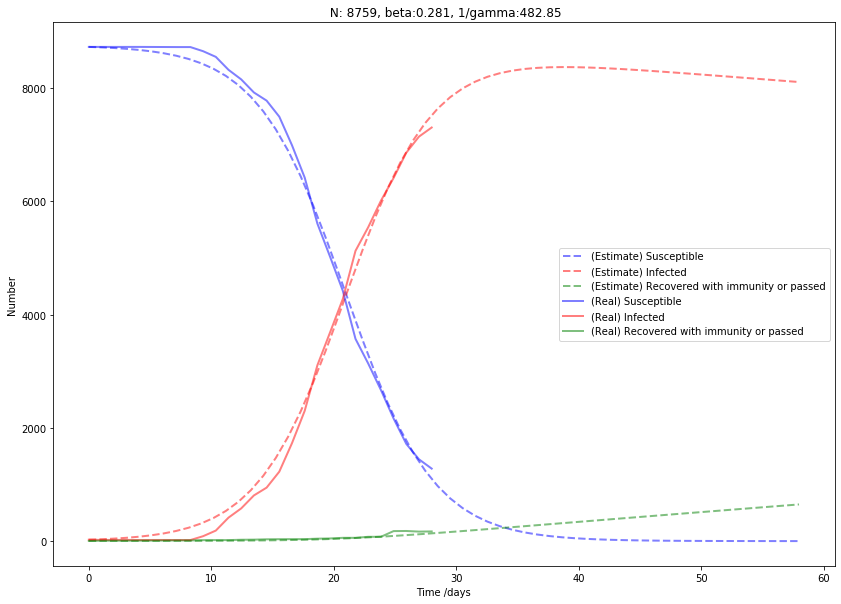

In [14]:
confirmed, deaths, recovered = get_data_by_country("South Korea")

offset = 20
confirmed = confirmed[offset:]
deaths = deaths[offset:]
recovered = recovered[offset:]

model = SIRModel(confirmed, deaths, recovered, N = int(max(confirmed)), beta = 3.5, gamma = 1./14)

estimates, best_p, best_N = model.grid_search(min_population = int(max(model.infected)),
                                              max_population = int(max(model.infected) * 1.5),
                                              step_count = 30)

plot_sir(model, best_p, best_N, 30)

## SIR prediction for China

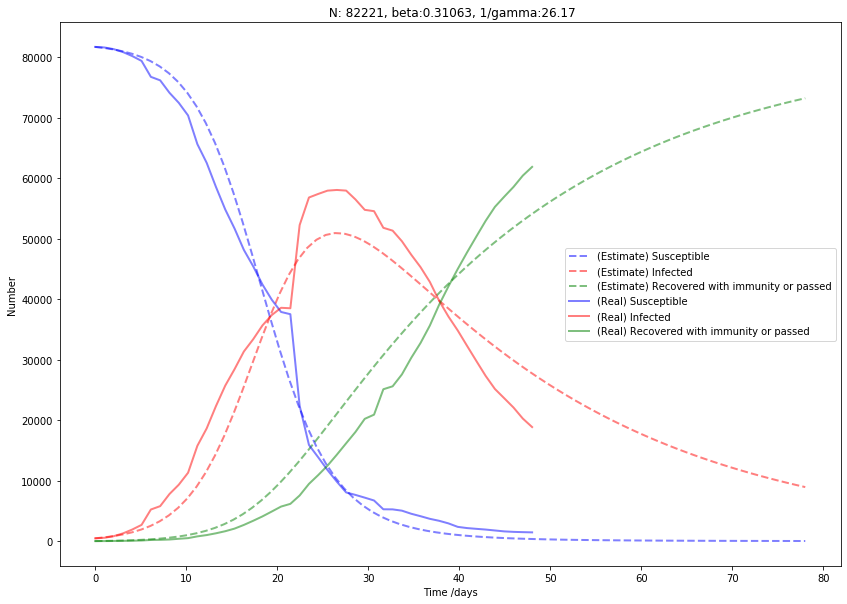

In [15]:
confirmed, deaths, recovered = get_data_by_country("Mainland China")

offset = 0
confirmed = confirmed[offset:]
deaths = deaths[offset:]
recovered = recovered[offset:]

model = SIRModel(confirmed, deaths, recovered, N = int(max(confirmed)), beta = 3.5, gamma = 1./14)

estimates, best_p, best_N = model.grid_search(min_population = int(max(model.infected)),
                                              max_population = int(max(model.infected) * 1.5),
                                              step_count = 30)

plot_sir(model, best_p, best_N, 30)

## SIR prediction for Italy

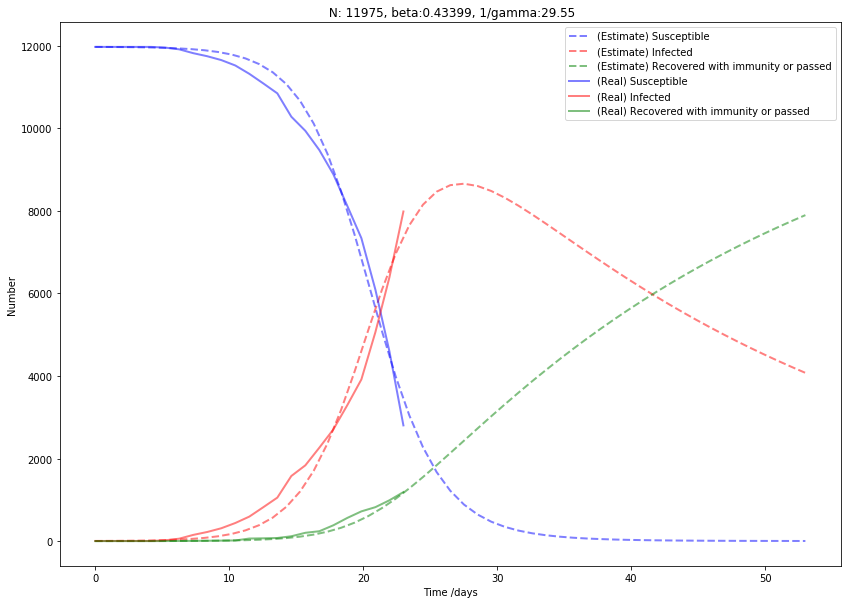

In [16]:
confirmed, deaths, recovered = get_data_by_country("Italy")

offset = 25
confirmed = confirmed[offset:]
deaths = deaths[offset:]
recovered = recovered[offset:]

model = SIRModel(confirmed, deaths, recovered, N = int(max(confirmed)), beta = 3.5, gamma = 1./14)

estimates, best_p, best_N = model.grid_search(min_population = int(max(model.infected)),
                                              max_population = int(max(model.infected) * 1.5),
                                              step_count = 30)

plot_sir(model, best_p, best_N, 30)

## SIR prediction for France

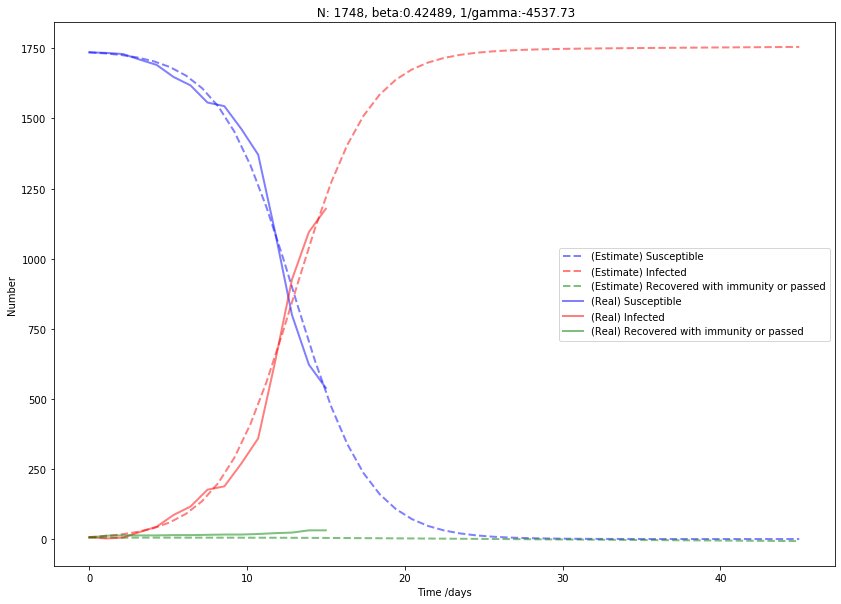

In [17]:
confirmed, deaths, recovered = get_data_by_country("France")

offset = 33
confirmed = confirmed[offset:]
deaths = deaths[offset:]
recovered = recovered[offset:]

model = SIRModel(confirmed, deaths, recovered, N = int(max(confirmed)), beta = 3.5, gamma = 1./14)

estimates, best_p, best_N = model.grid_search(min_population = int(max(model.infected)),
                                              max_population = int(max(model.infected) * 1.5),
                                              step_count = 30)

plot_sir(model, best_p, best_N, 30)